# Customer Churn Prediction
The dataset is available in kaggle -> https://www.kaggle.com/shubh0799/churn-modelling

This notebook focuses on the feature engineering part of the task.

In [28]:
# Required libs
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=SettingWithCopyWarning)

# Make figures inline
%matplotlib inline

In [29]:
# Load data set
c_data = pd.read_csv('data/Churn_Modelling.csv', index_col='RowNumber')
c_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
# Examine the customer churn target label
c_data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#### Can observe imbalanced target label classes. Oversampling technique can be used later to overcome this issue.


In [31]:
# check for missing values
c_data.isnull().any()

CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [32]:
# Remove meaningless features
c_data.drop(['CustomerId','Surname'], axis=1, inplace=True)

In [33]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [34]:
c_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Exploring CreditScore & Balance vs Exited features

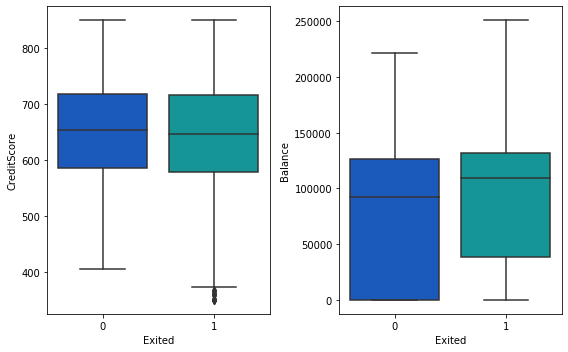

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))

sns.boxplot(y = 'CreditScore', x = 'Exited', data = c_data, palette = 'winter', ax=axes[0])
sns.boxplot(y = 'Balance', x = 'Exited', data = c_data, palette = 'winter', ax=axes[1])
fig.tight_layout()

#### Exploring Geography feature

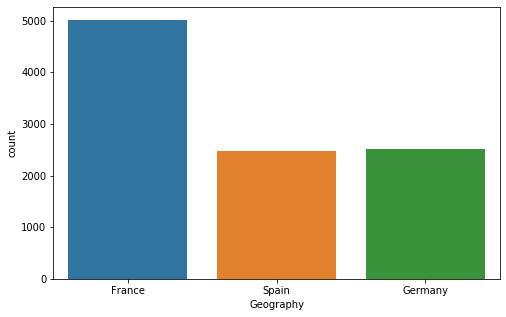

In [36]:
plt.figure(figsize=(8, 5))
plt.style.use('default')
sns.countplot(x = 'Geography' , data = c_data)

#### Exploring correlations among features using correlation heatmap

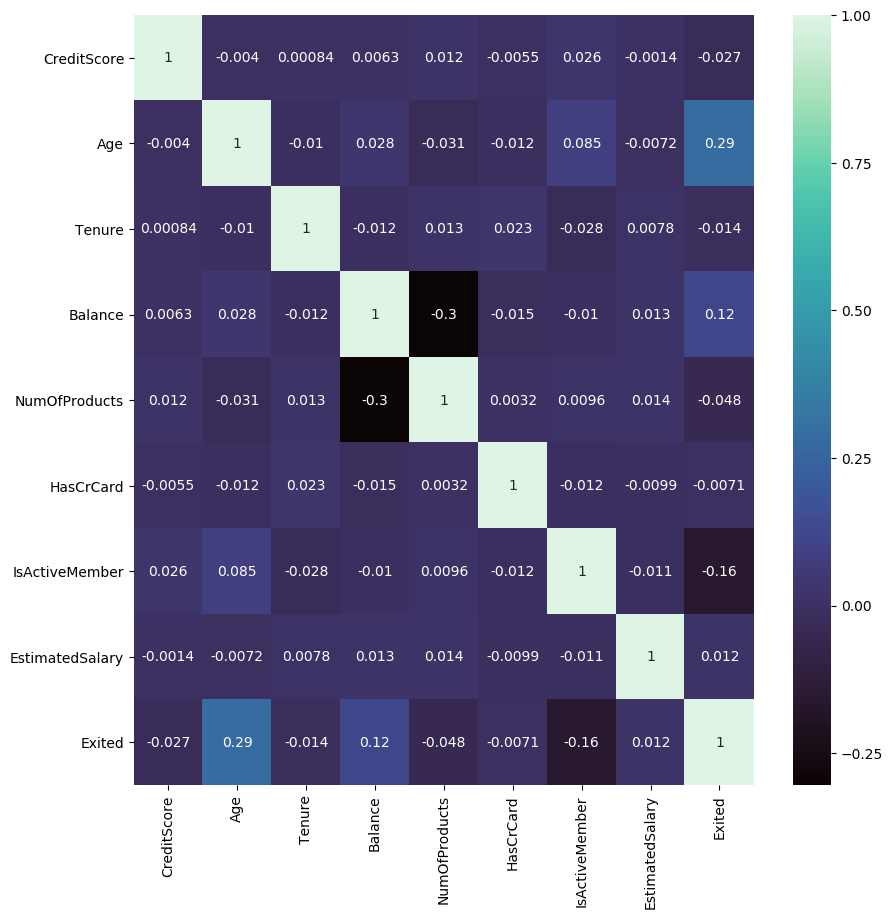

In [37]:
plt.figure(figsize=(10, 10))
sns.heatmap(c_data.select_dtypes(include='number').corr(), annot = True, cmap = 'mako')

Some correlation (when compared with others) can be seen among 'Exited' vs 'Age', 'Balance', 'IsActiveMember' features and 'NumOfProducts' vs 'Balance'

#### Comparing pairplot and heatmap positive/negetive correlations

<Figure size 800x600 with 0 Axes>

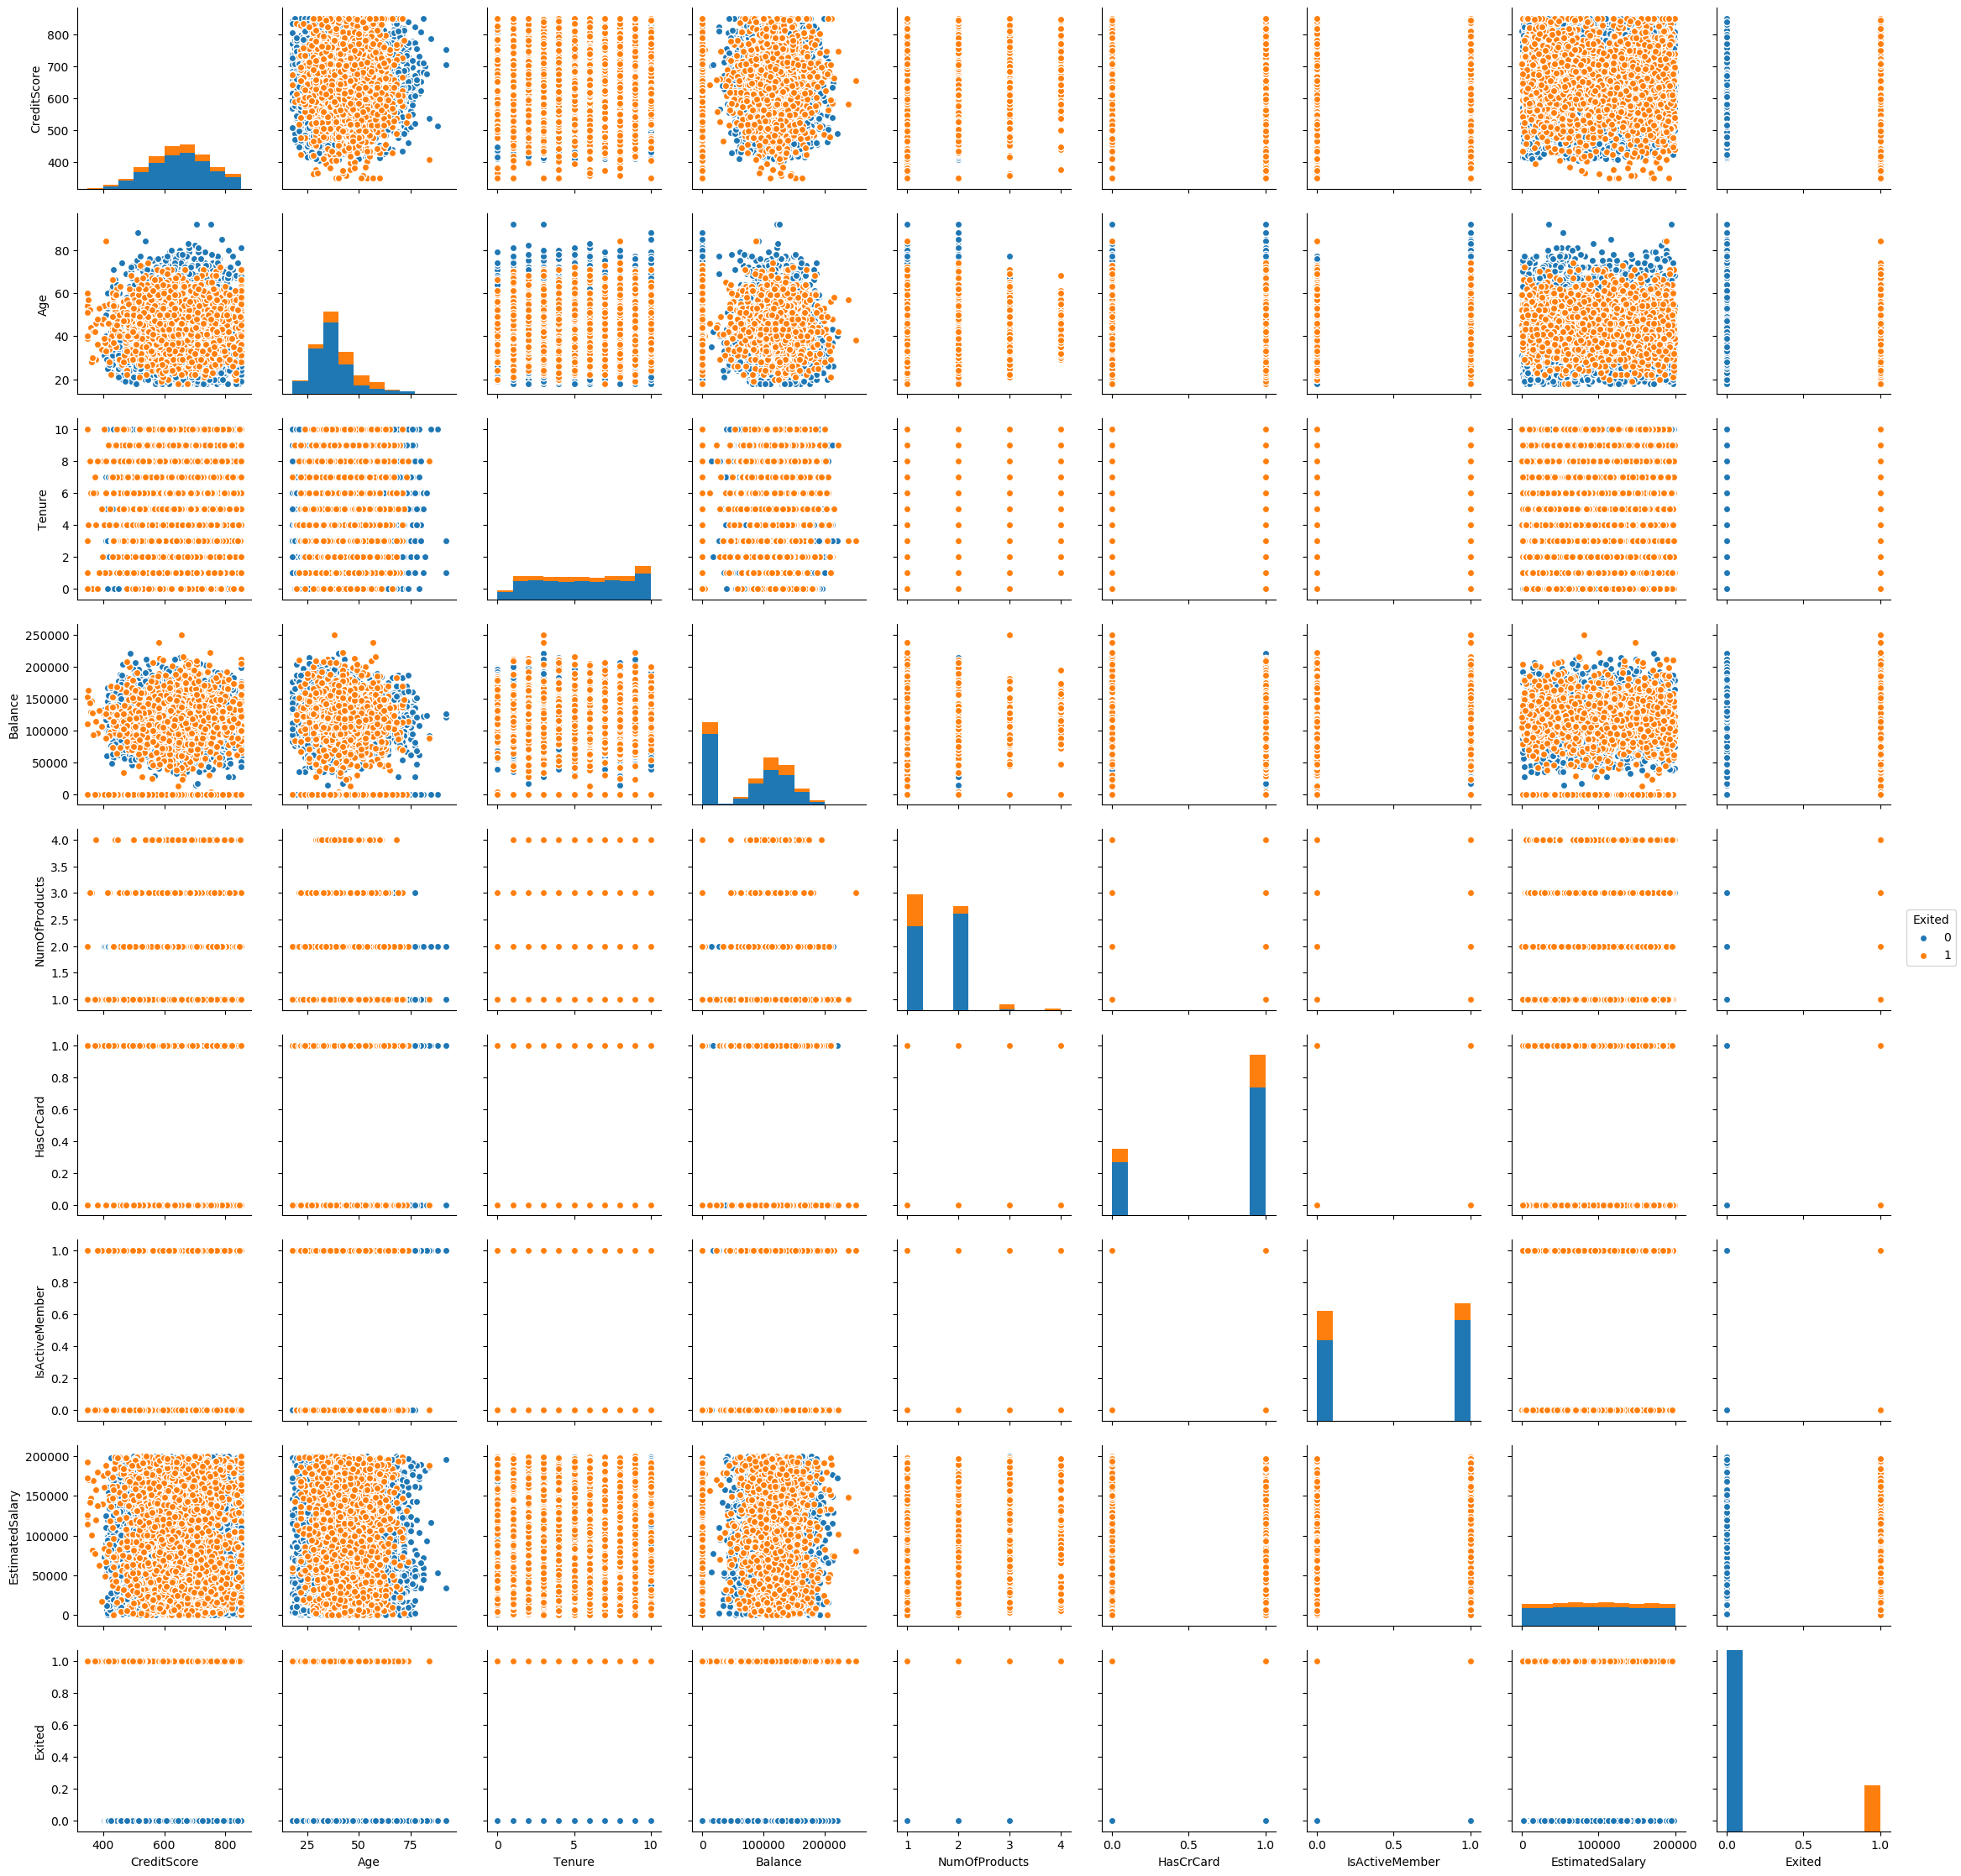

In [38]:
# visualizing with pairplots
plt.figure(figsize=(8, 6))
sns.pairplot(c_data, hue='Exited')

### Feature Engineering
 - Split independant/dependent features
 - Train/test split
 - Label encode categorical features
 - Oversample imbalanced classes
 - Normalize (required) features

In [39]:
# drop index column
c_data.reset_index(drop=True, inplace=True)

# split x,y lables (independant, dependant features)
X = c_data.iloc[:, :-1]
Y = c_data.iloc[:, -1].astype('float')

In [40]:
# Train test dataset splitting
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)

In [41]:
# get categorical features columns in a list
categorical_features = [col for col in c_data.select_dtypes(exclude='number').columns]
categorical_features

['Geography', 'Gender']

In [42]:
# label encoder object
le = LabelEncoder()

# label encode the categorical features
x_train[categorical_features] = x_train[categorical_features].apply(le.fit_transform)
x_test[categorical_features] = x_test[categorical_features].apply(le.fit_transform)

Note: If you perform the encoding before the split, it will lead to data leakage (train-test contamination). In the sense, you will introduce new data (integers of Label Encoders) and use it for your models thus it will affect the end predictions results (good validation scores but poor in deployment).

### Oversample to generate synthetic data to overcome class imbalance in labels

SMOTE-NC technique is used here. 
 - SMOTE (Synthetic Minority Over-sampling Technique) is a technique based on nearest neighbors judged by Euclidean Distance between data points in feature space.
 - SMOTE-NC (SMOTE for Nominal and Continuous features) creates synthetic data for categorical as well as quantitative features in the data set. SMOTE-NC slightly changes the way a new sample is generated by performing something specific for the categorical features. In fact, the categories of a new generated sample are decided by picking the most frequent category of the nearest neighbors present during the generation. 

Note:  It is important to apply SMOTE to the training set and not the testing set to avoid contaminating and introducing biases into the models. Basically you want to add synthetic data to the training set and keep the testing set with original data.

In [43]:
# Obtain column index of categorical features
cat_index = [index for (index, col) in enumerate(x_train.columns) if col in categorical_features]

# initiate SMOTENC object
sm = SMOTENC(categorical_features=cat_index) # random_state=123, sampling_strategy=.6

# oversample training data set
x_train, y_train = sm.fit_resample(x_train, y_train)

# check oversampled training dataset
print(x_train.shape, y_train.shape)
print(y_train.value_counts())

(10320, 10) (10320,)
1.0    5160
0.0    5160
Name: Exited, dtype: int64


In [44]:
c_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Normalizing features
Here normalizing only required features. No point in normalizing/scaling encoded categorical variables since the meaning will be lost.

In [45]:
# MinMaxScaler object
norm = MinMaxScaler()

# required columns to normalize
cols_to_norm = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

# fit to train set and transform both train and test sets
x_train[cols_to_norm] = norm.fit_transform(x_train[cols_to_norm])

x_test[cols_to_norm] = norm.transform(x_test[cols_to_norm])

#### Write out all train/test data

In [46]:
x_train.to_csv('data/train_features.csv', index=False)
x_test.to_csv('data/test_features.csv', index=False)

y_train.to_csv('data/train_labels.csv', index=False)
y_test.to_csv('data/test_labels.csv', index=False)